In [88]:
import os
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from rbf_neural_networks import RBFExperiment
from PIL import Image

# 1 - IRIS Dataset

In [89]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
print(f"iris dataset: X_train shape: {X.shape}, y_train shape: {y.shape}")

iris dataset: X_train shape: (150, 4), y_train shape: (150,)


In [91]:
experiment_iris = RBFExperiment(
    data_name="Iris Dataset",
    num_centers=10,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    learning_rate=0.01,
    epochs=100
)

In [92]:
experiment_iris.train()
experiment_iris.predict()

weights: [[ 0.00214912  0.19452071 -0.00872039]
 [ 0.35384493 -0.01566409  0.00339137]
 [-0.0045778   0.1525797   0.07752406]
 [-0.01233386  0.00470198  0.22722453]
 [ 0.01007941  0.18681537  0.00815158]
 [-0.02161915  0.10450764  0.1342704 ]
 [ 0.3660541   0.00333198 -0.00643177]
 [-0.00563826 -0.03967169  0.21531608]
 [-0.00487032  0.09613246  0.12265722]
 [ 0.0614907   0.15154821 -0.04733703]]


In [93]:
overall_acc, class_acc = experiment_iris.accuracy()

print(f"Test Accuracy: {overall_acc * 100:.2f}%")
for c, acc in class_acc.items():
    print(f"Accuracy class {c}: {acc * 100:.2f}%")

Test Accuracy: 96.67%
Accuracy class 0: 100.00%
Accuracy class 1: 100.00%
Accuracy class 2: 90.91%


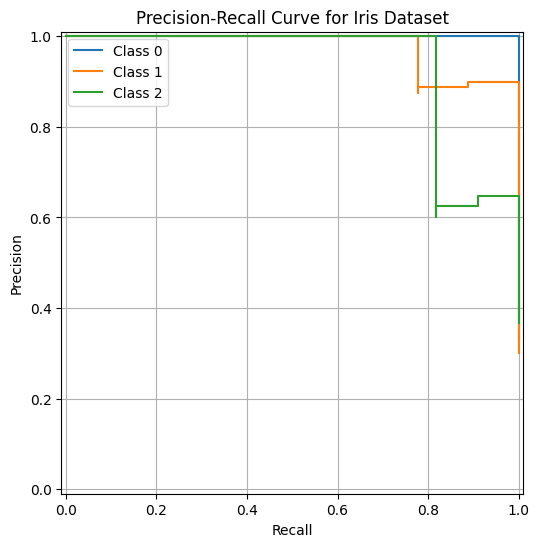

In [94]:
experiment_iris.plot_precision_recall_multiclass()

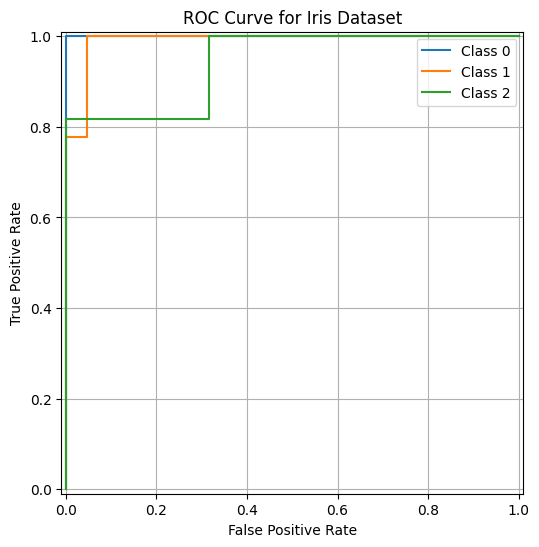

In [95]:
experiment_iris.plot_roc_multiclass()

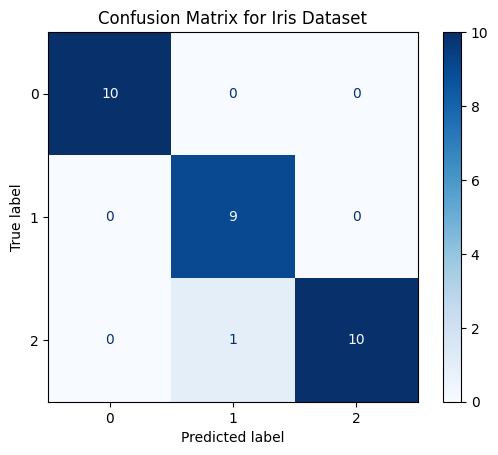

In [96]:
experiment_iris.plot_confusion_matrix()

# 2 - Rice Dataset

In [97]:
def load_images(folder, num_images=None, size=(128, 128)):
    images = []
    files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.png'))]
    
    if (num_images is not None):
        files = files[:num_images]
    
    for filename in files:
        try:
            img = Image.open(os.path.join(folder, filename))
            img = img.resize(size)
            img = np.array(img)
            if img.shape == (size[0], size[1], 3):
                images.append(img)  
        except:
            continue
    return np.array(images)

In [98]:
arborio_dir = "Rice_Image_Dataset/Arborio"
basmati_dir = "Rice_Image_Dataset/Basmati"
ipsala_dir = "Rice_Image_Dataset/Ipsala"
jasmine_dir = "Rice_Image_Dataset/Jasmine"
karcadag_dir = "Rice_Image_Dataset/Karacadag"

# Load images from each variety
arborio_images = load_images(arborio_dir)
basmati_images = load_images(basmati_dir)
ipsala_images = load_images(ipsala_dir)
jasmine_images = load_images(jasmine_dir)
karcadag_images = load_images(karcadag_dir)

# Create labels
arborio_labels = np.zeros(len(arborio_images))
basmati_labels = np.ones(len(basmati_images))
ipsala_labels = np.full(len(ipsala_images), 2)
jasmine_labels = np.full(len(jasmine_images), 3)
karcadag_labels = np.full(len(karcadag_images), 4)

In [99]:
# Combine data
X_rice = np.concatenate((arborio_images, basmati_images, ipsala_images, jasmine_images, karcadag_images), axis=0)
y_rice = np.concatenate((arborio_labels, basmati_labels, ipsala_labels, jasmine_labels, karcadag_labels), axis=0)

# Shuffle data
X_rice, y_rice = shuffle(X_rice, y_rice, random_state=42)

Shape X: (15000, 128, 128, 3)
Shape y: (15000,)


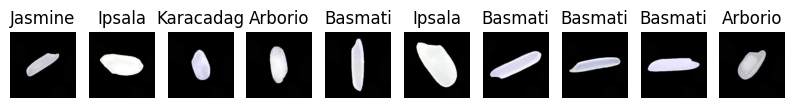

In [100]:
print("Shape X:", X_rice.shape)
print("Shape y:", y_rice.shape)

# Show some images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_rice[i])
    plt.title("Arborio" if y_rice[i]==0 else "Basmati" if y_rice[i]==1 else "Ipsala" if y_rice[i]==2 else "Jasmine" if y_rice[i]==3 else "Karacadag")
    plt.axis('off')
plt.show()

In [101]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_rice, y_rice, test_size=0.2, random_state=42)

experiment_rice = RBFExperiment(
    data_name="Rice Dataset",
    num_centers=10,
    X_train=X_train2,
    y_train=y_train2,
    X_test=X_test2,
    y_test=y_test2,
    learning_rate=0.01,
    epochs=100
)